In [1]:
import pyswmm
import sys, os
import pystorms
import numpy as np
import pandas as pd
from pyswmm import Output
import matplotlib.pyplot as plt
from swmm.toolkit.shared_enum import NodeAttribute

In [2]:
input_file = pystorms.networks.load_network("epsilon")

In [3]:
simulation = pyswmm.Simulation(inputfile=input_file)
simulation.execute();


... SWMM Version 5.2.3
... Run Complete
 o  Retrieving project data
 o  Simulating day: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 0     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 1     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 2     hour: 3     hour: 3     hour: 3     hour: 3     hour:

In [8]:
weirs = {"ISD001": "004",
         "ISD002": "006",
         "ISD003": "011",
         "ISD004": "022",
         "ISD005": "027",
         "ISD006": "030",
         "ISD007": "033",
         "ISD008": "039",
         "ISD009": "044",
         "ISD010": "050",
         "ISD011": "060"}

In [9]:
output_file = input_file[:-3] + "out"

In [40]:
out = Output(output_file)

In [41]:
depth = pd.DataFrame()
for node_id in list(weirs.values()):
    depth_i = out.node_series(node_id, attribute=NodeAttribute.INVERT_DEPTH)
    depth = pd.concat([depth, pd.DataFrame(data={node_id: depth_i.values()}, index=depth_i.keys())], axis=1)

<Axes: >

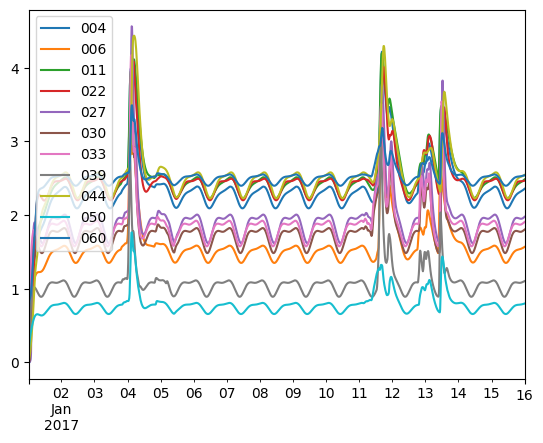

In [42]:
depth.plot()

### Corrupt Data

1. add noise on data for couple of days
2. add nan or "None" values
3. flat lines randomly

In [43]:
depth["time"] = depth.index.values

In [44]:
depth["time"] = (depth['time'] - depth['time'][0]).apply(lambda x: x.total_seconds())

In [45]:
depth_noisy = pd.DataFrame()
for sensor in depth.columns:
    # generate sample noise
    noise = np.random.default_rng().uniform(0.1,0.5, 1)
    depth_noisy[sensor] = depth[sensor] + np.random.normal(0.0, noise, depth.shape[0])

In [46]:
for _ in range(0, 20):
    columns = np.random.choice(11, 4, replace=False)
    day = np.random.choice(np.linspace(1, 15, 15, dtype=int), 1)[0]
    hour = np.random.choice(np.linspace(1, 23, 23, dtype=int), 1)[0]
    start_time = pd.Timestamp(f"2017-01-{day} {hour}:00:00")
    end_time = start_time + pd.Timedelta("1hr")
    for i_c in columns:
        depth_noisy.iloc[:,i_c].loc[start_time] = depth.iloc[:,i_c].loc[start_time] + np.random.normal(depth.iloc[:,i_c].loc[start_time], 10.0)

<Axes: >

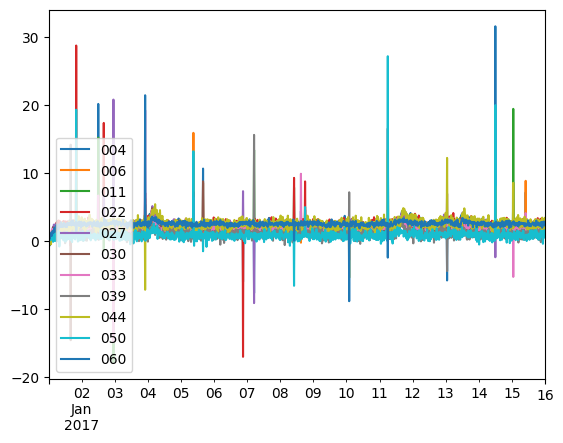

In [47]:
depth_noisy[['004', '006', '011', '022', '027', '030', '033', '039', '044', '050','060']].plot()

<Axes: >

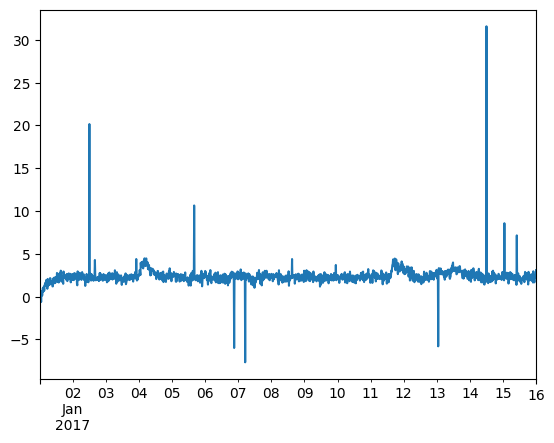

In [49]:
depth_noisy['004'].plot()

In [62]:
from sklearn.linear_model import SGDOneClassSVM
X = depth_noisy['004'].values.reshape(-1, 1)
clf = SGDOneClassSVM(random_state=42)
y = clf.fit(X).predict(X)

ValueError: array([-1, -1, -1, ...,  1,  1,  1], dtype=int32) is not a valid value for color

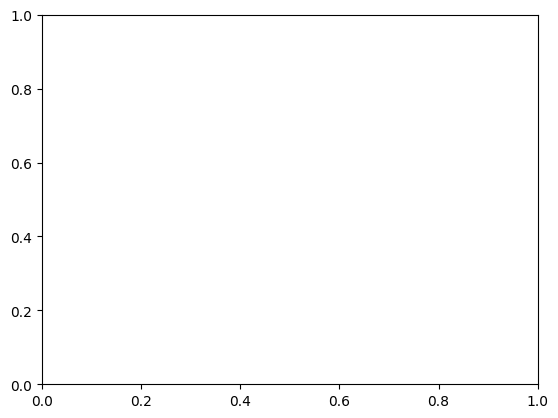

In [69]:
plt.plot(X, color=y)

In [12]:
for _ in range(0, 5):
    columns = np.random.choice(11, 4, replace=False)
    day = np.random.choice(np.linspace(1, 15, 15, dtype=int), 1)[0]
    hour = np.random.choice(np.linspace(1, 23, 23, dtype=int), 1)[0]
    start_time = pd.Timestamp(f"2017-01-{day} {hour}:00:00")
    end_time = start_time + pd.Timedelta("3hr")
    depth_noisy.loc[start_time:end_time,].iloc[columns] = np.nan

In [13]:
for _ in range(0, 10):
    columns = np.random.choice(11, 4, replace=False)
    day = np.random.choice(np.linspace(1, 15, 15, dtype=int), 1)[0]
    hour = np.random.choice(np.linspace(1, 23, 23, dtype=int), 1)[0]
    start_time = pd.Timestamp(f"2017-01-{day} {hour}:00:00")
    end_time = start_time + pd.Timedelta("1hr")
    for i_c in columns:
        depth_noisy.iloc[:,i_c].loc[start_time:end_time] = depth.loc[start_time].iloc[i_c]

<Axes: >

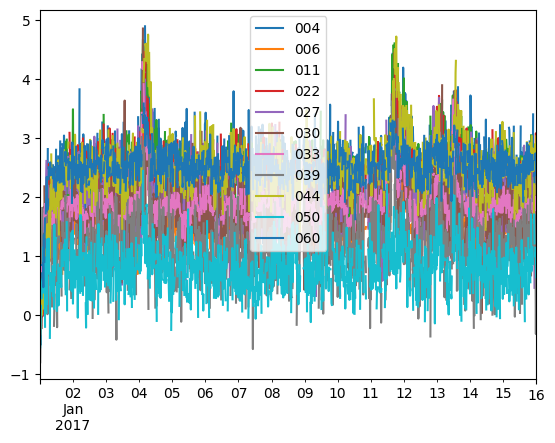

In [15]:
def fourier_filtering(f, t, dt, psd_threshold):
    n = len(t)
    fhat = np.fft.fft(f,n)                     # Compute the FFT
    PSD = fhat * np.conj(fhat) / n             # Power spectrum (power per freq)
    freq = (1/(dt*n)) * np.arange(n)           # Create x-axis of frequencies in Hz
    L = np.arange(1,np.floor(n/2),dtype='int') # Only plot the first half of freqs
    indices = PSD > psd_threshold    # Find all freqs with large power
    PSDclean = PSD * indices  # Zero out all others
    fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
    ffilt = np.fft.ifft(fhat) # Inverse FFT for filtered time signal
    return freq, PSD, ffilt, L, PSDclean

In [35]:
freq, PSD, ffilt, L, PSDclean = fourier_filtering(f=depth_noisy['004'].dropna().values,
                                                  t=depth_noisy['time'].values,
                                                  dt=1/900.0,
                                                  psd_threshold=2.0)

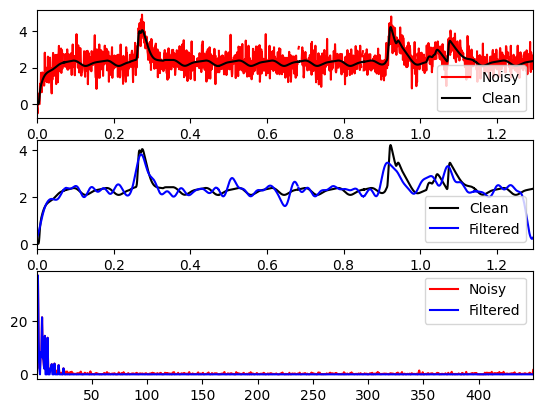

In [36]:
## Plots
t=depth_noisy['time'].values
f=depth_noisy['004'].values
f_clean = depth['004'].values

fig,axs = plt.subplots(3,1)

plt.sca(axs[0])
plt.plot(t,f,color='r', label='Noisy')
plt.plot(t,f_clean,color='k', label='Clean')
plt.xlim(t[0],t[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(t,f_clean,color='k',label='Clean')
plt.plot(t,ffilt,color='b',label='Filtered')
plt.xlim(t[0],t[-1])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L],PSD[L],color='r', label='Noisy')
plt.plot(freq[L],PSDclean[L],color='b', label='Filtered')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.legend()

plt.show()

Question:

1. Data usually has noise, how do we filter it?
- Fourier filtering

In [46]:
np.random.normal(1.0, 10.0)

-4.106221033537461

In [52]:
pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 9.7 MB/s eta 0:00:00m eta 0:00:0100:0101
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 9.3 MB/s eta 0:00:00
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.
